Sharpe Ratio (Mean): 3.525249758559354
Final Cumulative Return: 0.3851662844765087
Overall R^2: 0.13886063999959852


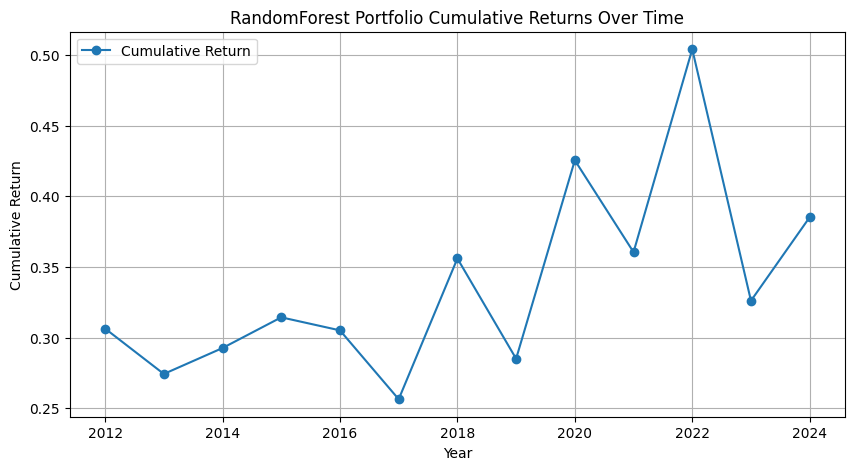

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# ----------------------------
# 1. Data Loading and Preprocessing
# ----------------------------
# Use the new file path that includes tickers
df_equity = pd.read_csv("../data/cleaned_df_with_tickers.csv")
df_equity['Date'] = pd.to_datetime(df_equity['Date'])

risk_free_file = "risk_free_rate.csv"
df_risk_free = pd.read_csv(risk_free_file)
df_risk_free['Date'] = pd.to_datetime(df_risk_free['Date'])

# Merge equity data with Risk-Free Rate data on Date
df = pd.merge(df_equity, df_risk_free, on='Date', how='left')

# Define features and target variable.
# Remove columns that should not be used for model training.
features = df.columns.tolist()
for col in ['Ticker', 'Date', 'risk_premium', 'Risk_Free_Rate']:
    if col in features:
        features.remove(col)
target = 'risk_premium'

# ----------------------------
# 2. Rolling Window Forecasting with Monthly Excess Returns
#    (Random Forest version with Daily Predictions then Monthly Rebalancing)
# ----------------------------
def rolling_window_forecast_rf_monthly(df, base_model):
    daily_predictions_rf = []  # To store daily predictions for later monthly rebalancing
    y_actual_all_rf = []
    y_pred_all_rf = []

    years = sorted(df['Date'].dt.year.unique())
    for test_year in years:
        if test_year < 2012:
            continue

        # Define training, validation, and test periods using a rolling window approach.
        train_start_date = pd.Timestamp(f"{test_year - 12}-01-01")
        train_end_date = pd.Timestamp(f"{test_year - 2}-12-31")
        val_start_date = pd.Timestamp(f"{test_year - 1}-01-01")
        val_end_date = pd.Timestamp(f"{test_year - 1}-12-31")
        test_start_date = pd.Timestamp(f"{test_year}-01-01")
        test_end_date = pd.Timestamp(f"{test_year}-12-31")

        train_data = df[(df['Date'] >= train_start_date) & (df['Date'] <= train_end_date)]
        val_data = df[(df['Date'] >= val_start_date) & (df['Date'] <= val_end_date)]
        test_data_year = df[(df['Date'] >= test_start_date) & (df['Date'] <= test_end_date)]

        if train_data.empty or val_data.empty or test_data_year.empty:
            continue

        X_train = train_data[features]
        y_train = train_data[target]
        X_val = val_data[features]
        y_val = val_data[target]
        X_test_year = test_data_year[features]
        y_test_year = test_data_year[target]

        # Set up randomized parameter search for Random Forest.
        param_dist = {
            'n_estimators': [25, 50],
            'max_depth': [5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }

        grid = RandomizedSearchCV(estimator=base_model, param_distributions=param_dist,
                                  scoring='r2', cv=2, n_iter=5, n_jobs=-1, random_state=42)
        grid.fit(X_train, y_train)
        best_params = grid.best_params_
        model_tuned = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)

        # Fit model on combined training and validation data.
        X_train_val = pd.concat([X_train, X_val], axis=0)
        y_train_val = pd.concat([y_train, y_val], axis=0)
        model_tuned.fit(X_train_val, y_train_val)

        # Get daily predictions for the test year.
        predictions_year = model_tuned.predict(X_test_year)

        # Preserve the "Ticker" column for later grouping. Add daily predicted risk premium.
        test_data_year = test_data_year.copy()
        test_data_year.loc[:, 'predicted_risk_premium'] = predictions_year

        daily_predictions_rf.append(test_data_year)
        y_actual_all_rf.extend(y_test_year)
        y_pred_all_rf.extend(predictions_year)

    # Combine all daily predictions across test years.
    daily_predictions_rf = pd.concat(daily_predictions_rf)

    # ----------------------------
    # Monthly Rebalancing using Daily Predictions
    # ----------------------------
    portfolio_returns_rf = []

    for year in sorted(daily_predictions_rf['Date'].dt.year.unique()):
        test_data_year = daily_predictions_rf[daily_predictions_rf['Date'].dt.year == year]
        monthly_returns_rf = []

        for month in range(1, 13):
            test_data_month = test_data_year[test_data_year['Date'].dt.month == month]
            if test_data_month.empty:
                continue

            # Group stocks into deciles based on predicted risk premiums.
            test_data_month = test_data_month.copy()
            test_data_month.loc[:, 'decile'] = pd.qcut(test_data_month['predicted_risk_premium'], q=10, labels=False)

            # Use risk_premium (which is excess return) as the actual return.
            top_decile_returns = test_data_month[test_data_month['decile'] == 9]['risk_premium'].mean()
            bottom_decile_returns = test_data_month[test_data_month['decile'] == 0]['risk_premium'].mean()
            long_short_return_month = top_decile_returns - bottom_decile_returns

            avg_risk_free_rate_month = test_data_month['Risk_Free_Rate'].mean()

            monthly_returns_rf.append({
                'Month': month,
                'Long-Short Return': long_short_return_month,
                'Risk-Free Rate': avg_risk_free_rate_month,
                'Excess Return': long_short_return_month  # Already an excess return measure
            })

        if monthly_returns_rf:
            monthly_df_rf = pd.DataFrame(monthly_returns_rf)
            yearly_cumulative_return_rf = (1 + monthly_df_rf['Long-Short Return']).prod() - 1
            sharpe_ratio = (monthly_df_rf['Excess Return'].mean() / monthly_df_rf['Excess Return'].std() 
                            if monthly_df_rf['Excess Return'].std() != 0 else 0)
            portfolio_returns_rf.append({
                'Year': year,
                'Yearly Cumulative Return': yearly_cumulative_return_rf,
                'Sharpe Ratio': sharpe_ratio,
            })

    return {
        "y_actual": y_actual_all_rf,
        "y_pred": y_pred_all_rf,
        "portfolio_returns": portfolio_returns_rf
    }

# ----------------------------
# Main Execution Code
# ----------------------------
base_model_rf = RandomForestRegressor(random_state=42, n_jobs=-1)
results_rf = rolling_window_forecast_rf_monthly(df, base_model_rf)

# Save actual and predicted values to a CSV file for DM test purposes.
dm_test_df_rf = pd.DataFrame({
    'y_actual': results_rf['y_actual'],
    'y_pred': results_rf['y_pred']
})
dm_test_df_rf.to_csv('dm_test_results_RF.csv', index=False)

portfolio_df_rf = pd.DataFrame(results_rf['portfolio_returns'])
portfolio_df_rf.to_csv('RandomForest_portfolio_performance_monthly.csv', index=False)

print("Sharpe Ratio (Mean):", portfolio_df_rf['Sharpe Ratio'].mean())
print("Final Cumulative Return:", portfolio_df_rf['Yearly Cumulative Return'].iloc[-1])
print("Overall R^2:", r2_score(results_rf['y_actual'], results_rf['y_pred']))

plt.figure(figsize=(10, 5))
plt.plot(portfolio_df_rf['Year'], portfolio_df_rf['Yearly Cumulative Return'], marker='o', label='Cumulative Return')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.title('RandomForest Portfolio Cumulative Returns Over Time')
plt.legend()
plt.grid()
plt.show()